# Proteomic Data Aggregation and Visualization


This notebook demonstrates aggregation of proteomic data via the National Microbiome Data Collaborative (NMDC)'s [Runtime API](https://api.microbiomedata.org/docs). It highlights how the NMDC's schema can be used to overcome some of the numerous challenges associated with this type of aggregation. Please note that this notebook is intended for individuals with experience performing mass spectrometry based analyses and that various parameter and processing choices were made for this example use case. They are not broadly applicable and should be adjusted as needed. 


Notebook Steps:

1) Assess background information and collect datasets for an example study of riverbed sediment along the Columbia River

2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

3) Collapse to unique peptides and normalize quantification

4) Generate protein mappings using "Razor" strategy

5) Extract functional gene annotations for these proteins

6) Gather metadata for the 33 biosamples associated with these processed datasets

7) Perform protein rollup using the "Razor" results and summarize into an aggregated table of relative protein abundance


Import libraries and python scripts containing functions necessary to run this notebook. 'aggregation_functions.py' (also in this folder) includes spectral probability filtering and protein mapping functions. 'nmdc_api.py' (located in NOM_visualization/python) includes functions for API traversal of the collections endpoint

In [1]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

if 'google.colab' in sys.modules:

   ##TODO: update these TWO links when pushed to main

   #module in this folder with specific protein aggregation functions
   !wget https://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/95-create-notebook-that-aggregates-proteomic-workflow-outputs-and-visualizes-the-results/proteomic_aggregation/python/aggregation_functions.py
   import aggregation_functions as agg_func

   #pmartR logo
   !wget https://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/95-create-notebook-that-aggregates-proteomic-workflow-outputs-and-visualizes-the-results/proteomic_aggregation/pmartR_logo_final.jpg
   
   #module for API functions currently residing in NOM_visualizations
   !wget https://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/NOM_visualizations/python/nmdc_api.py
   import nmdc_api as api_func

else:
  #module in this folder with specific protein aggregation functions
  import aggregation_functions as agg_func

  #module for API functions currently residing in NOM_visualizations
  api_func=agg_func.import_relative_module("nmdc_api", "../../NOM_visualizations/python/nmdc_api.py")

## 1) Assess background information and collect data for an example study of riverbed sediment along the Columbia River

Review the example study on the [NMDC data portal](https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51). Use the study `id` embedded in the url (nmdc:sty-11-aygzgv51) to collect all related data objects via the [NMDC Runtime API](https://api.microbiomedata.org/docs) and reformat the yaml output into a pandas dataframe

In [2]:
pd.set_option("display.max_rows", 6)

#get all data objects associated with this study id using the NMDC find endpoint
og_url = f'https://api.microbiomedata.org/data_objects/study/nmdc:sty-11-aygzgv51?&max_page_size=100'
resp = requests.get(og_url)
data = resp.json()
data = pd.DataFrame(data)
del resp, og_url

#reformat data into dataframe (keeping biosample id)
data_objects=[]
for index, row in data.iterrows():
    bio_id = row['biosample_id']
    row_out = row.explode('data_objects').drop_duplicates()
    row_out = pd.json_normalize(row_out)
    row_out['biosample_id'] = bio_id
    data_objects.append(row_out)

data_objects = pd.concat(data_objects)
display(data_objects)

del data, index, row, row_out, bio_id

,id,name,description,file_size_bytes,data_object_type,type,md5_checksum,url,was_generated_by,biosample_id,alternative_identifiers,in_manifest,data_category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmdc:bsm-13-amrnys72,NaN,NaN,NaN
1,nmdc:dobj-13-f605mj12,9289.1.128215.TCCTGAG-TATCCTC.fastq.gz,Raw sequencer read data,6.700068e+09,Metagenome Raw Reads,nmdc:DataObject,NaN,NaN,NaN,nmdc:bsm-13-amrnys72,NaN,NaN,NaN
2,nmdc:dobj-13-20vg7p81,nmdc_wfmgas-13-01678h03.1_contigs.fna,Assembled contigs fasta for nmdc:omprc-13-g765...,2.507473e+08,Assembly Contigs,nmdc:DataObject,3d9e14d6f7a854042a7d71def080409b,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-amrnys72,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,nmdc:dobj-13-a1288f79,Unground_SBR_Spring_2014_FC_S3_50-60_H2Oext_22...,EnviroMS FT ICR-MS natural organic matter work...,1.399500e+04,FT ICR-MS Analysis Results,nmdc:DataObject,32d61ae97aae206e3a0a659ac26c9207,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-y8faan47.1,nmdc:bsm-13-7sbt2x61,NaN,NaN,NaN
9,nmdc:dobj-13-h2j6dr08,output: Unground_SBR_Spring_2014_FC_S3_50-60_M...,High resolution MS spectra only,3.052338e+07,NaN,nmdc:DataObject,NaN,NaN,NaN,nmdc:bsm-13-7sbt2x61,[emsl:output_457949],NaN,NaN
10,nmdc:dobj-13-p84dp061,Unground_SBR_Spring_2014_FC_S3_50-60_MeOHExt_2...,EnviroMS FT ICR-MS natural organic matter work...,8.462700e+04,FT ICR-MS Analysis Results,nmdc:DataObject,719a8a2b088256e51518f63641ea197e,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-q5accv31.1,nmdc:bsm-13-7sbt2x61,NaN,NaN,NaN


Subset the data objects to 'Unfiltered Metaproteomic Results'. These files contain the proteomic workflow outputs that will be used for proteomic aggregation

In [3]:
proteomic_output_df = data_objects[data_objects['data_object_type']=='Unfiltered Metaproteomics Results'].reset_index(drop=True).rename(columns={'id':'processed_DO_id'})
display(proteomic_output_df)

,processed_DO_id,name,description,file_size_bytes,data_object_type,type,md5_checksum,url,was_generated_by,biosample_id,alternative_identifiers,in_manifest,data_category
0,nmdc:dobj-11-wcn69x37,nmdc_dobj-11-rrmg7w64_nmdc_dobj-11-532pnk74_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",7698320.0,Unfiltered Metaproteomics Results,nmdc:DataObject,bdc3191137d45d54afabca583205a872,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-kcdh3w94,NaN,[nmdc:manif-11-7796sg87],NaN
1,nmdc:dobj-11-bxyvx506,nmdc_dobj-11-xvmb4058_nmdc_dobj-11-bvya7a43_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",10580159.0,Unfiltered Metaproteomics Results,nmdc:DataObject,205bc0ca0620058a156011681d07832d,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-1p0tct86,NaN,[nmdc:manif-11-7796sg87],NaN
2,nmdc:dobj-11-z8hc0j30,nmdc_dobj-11-hp2vmj63_nmdc_dobj-11-716e7y35_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",8376109.0,Unfiltered Metaproteomics Results,nmdc:DataObject,8785b9538d977a50fd35d11bfcb037ce,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-2fw5j754,NaN,[nmdc:manif-11-7796sg87],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,nmdc:dobj-11-7psagy79,nmdc_dobj-11-erc74h90_nmdc_dobj-11-sekqwq68_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",10282205.0,Unfiltered Metaproteomics Results,nmdc:DataObject,7f35ff00b17f0d4e2bd5e62181005f43,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-3pvn5d70,NaN,[nmdc:manif-11-7796sg87],NaN
31,nmdc:dobj-11-tk9hc081,nmdc_dobj-11-e2309414_nmdc_dobj-11-0f1b2t61_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",8161710.0,Unfiltered Metaproteomics Results,nmdc:DataObject,4c9d199ca4c13e095a3d5caec558da9b,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-amdcp906,NaN,[nmdc:manif-11-7796sg87],NaN
32,nmdc:dobj-11-2szyc560,nmdc_dobj-11-tezmee57_nmdc_dobj-11-w2c1ee09_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",8117239.0,Unfiltered Metaproteomics Results,nmdc:DataObject,fd8a212ad33a8162857d0ca164760333,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-vqk1y255,NaN,[nmdc:manif-11-7796sg87],NaN


There are various requirements that enable mass spectrometry runs to be aggregated and analyzed together. For example, runs need to be performed in succession, on the same instrument. The NMDC schema can make it easier to find these proteomic results by linking them via a slot called `in_manifest`.

Look at the `in_manifest` id on these proteomic outputs to confirm that all runs are in the same manifest record, and pull that record. If that manifest record's `manifest_category` value is 'instrument_run', then it confirms that these are LC-MS/MS runs that were performed in succession on the same instrument. Proteomic outputs from different manifest records should not be aggregated.

In [4]:
#extract in_manifest ids for this study (in this case a single one available)
manifest_id = proteomic_output_df.explode('in_manifest')['in_manifest'].unique()

#determine manifest_category
manifest = api_func.get_id_results(newest_results=proteomic_output_df.to_dict(orient='records'), id_field = 'in_manifest', query_collection = 'manifest_set', match_id_field = 'id', query_fields = '')
display(manifest)

[{'id': 'nmdc:manif-11-7796sg87',
  'manifest_category': 'instrument_run',
  'type': 'nmdc:Manifest',
  'description': 'collection of metaproteomic analyses from the same instrument run nmdc:sty-11-aygzgv51'}]

Look at an example of the information in 'Unfiltered Metaproteomics Results', which contains peptide identification and relative abundance information

In [5]:
#example unfiltered results 
unfilt_results = proteomic_output_df.iloc[0]["url"]
print(unfilt_results)
display(agg_func.tsv_extract(unfilt_results))

del unfilt_results

https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-rrmg7w64_nmdc_dobj-11-532pnk74_msgfplus_syn_PlusSICStats.txt


,ResultID,Scan,FragMethod,SpecIndex,Charge,PrecursorMZ,DelM,DelM_PPM,MH,Peptide,...,PeakMaxIntensity,PeakSignalToNoiseRatio,FWHMInScans,PeakArea,ParentIonIntensity,ParentIonMZ,StatMomentsArea,PeakScanStart,PeakScanEnd,PeakWidthMinutes
0,1,36395,HCD,1,2,1098.00403,0.00318,1.44939,2193.994250,K.SAYPGQITSNMFCAGYLEGGK.D,...,242049.0,85.520,268,1.641300e+07,85675.0,1098.00,8.999200e+06,36001,36752,0
1,2,23937,HCD,2,3,721.68903,-0.00384,-1.77602,2163.056312,R.LGEDNINVVEGNEQFISASK.S,...,223900000.0,903.800,81,1.989200e+10,2994700.0,721.69,1.823700e+10,23819,24330,0
2,3,45758,HCD,3,2,1082.52820,-0.01067,-4.93472,2163.056312,R.LGEDNINVVEGNEQFISASK.S,...,1841600.0,5.298,334,5.948800e+08,1279900.0,1082.53,4.077900e+08,45649,46197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31923,31924,6605,HCD,26743,2,590.77094,-0.01103,-9.35603,1179.542201,R.MLDGDTERSR.H,...,172138.0,10.310,115,8.929200e+06,134262.0,590.77,3.611600e+06,6472,6623,0
31924,31925,25719,HCD,26744,2,1173.53979,-0.03561,-15.18653,2346.107833,-.KIEMHFLPDVYVPCETCHGK.R,...,239975.0,58.450,6,4.310700e+06,1304.7,1173.54,1.346400e+06,25637,25838,0
31925,31926,12373,HCD,26745,2,753.36945,0.01674,11.11853,1506.718237,R.EELDDPVRSQYR.E,...,484543.0,4.170,83,4.875100e+07,530695.0,753.37,1.752300e+07,12240,12401,0


Extract information from all 33 proteomic results via the function tsv_extract() in agg_func, and put them into a single dataframe, where each scan in each dataset has the unique identifier `SpecID`. Clean prefix and postfix off of each peptide sequence, then determine the type of protein being matched to each peptide: contaminant, reverse (false positive match to the reversed amino acid sequence of a protein), or forward (match to the true, forward amino acid sequence of a protein).

In [6]:
unfilt_res = agg_func.iterate_file_extract(identifier_col='processed_DO_id',
                                url_col='url',
                                extract_cols=['Charge','Scan','Peptide','Protein','MSGFDB_SpecEValue','StatMomentsArea'],
                                pd_df=proteomic_output_df,
                                filter_col = None,
                                filter_values = None,
                                file_type='tsv'
                                )


#create identifier for each scan in each dataset
unfilt_res["SpecID"] = unfilt_res.apply(lambda row: str(row["id_col"]) + "_" + str(row["Scan"]), axis=1)

#clean off the prefix and postfix from the sequence but keep any mods
unfilt_res["Peptide Sequence with Mods"] = unfilt_res["Peptide"].apply(agg_func.sequence_nopostpre)
del unfilt_res['Peptide']

#determine protein type (contaminant, reverse, forward)
unfilt_res["Protein_Type"] = unfilt_res["Protein"].apply(agg_func.findproteinname)

unfilt_res

,Charge,Scan,Protein,MSGFDB_SpecEValue,StatMomentsArea,id_col,SpecID,Peptide Sequence with Mods,Protein_Type
0,2,36395,Contaminant_TRYP_BOVIN,1.754200e-23,8.999200e+06,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_36395,SAYPGQITSNMFCAGYLEGGK,None
1,3,23937,Contaminant_TRYP_BOVIN,1.322500e-22,1.823700e+10,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_23937,LGEDNINVVEGNEQFISASK,None
2,2,45758,Contaminant_TRYP_BOVIN,2.022700e-22,4.077900e+08,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_45758,LGEDNINVVEGNEQFISASK,None
...,...,...,...,...,...,...,...,...,...
1040341,3,31259,XXX_nmdc:wfmgan-11-z0raab34.1_062580_2_376,4.998500e-07,2.905500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_31259,MNAAEANSHADPDHMGAISVATRLGELPHANK,Reversed
1040342,2,10035,nmdc:wfmgan-11-z0raab34.1_157112_40_279,4.998700e-07,5.271900e+09,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_10035,APDLMIFAK,Forward
1040343,3,4075,XXX_nmdc:wfmgan-11-z0raab34.1_020416_230_607,4.999200e-07,9.764500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_4075,EAESEEFRQRAK,Reversed


## 2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

A challenge associated with aggregating mass spectrometry data is that there are always false identifications, which can be mitigated by imposing a spectral probability filter on the data being analyzed. The same spectral probability filter needs to be applied across datasets when they are being compared. The filter value itself is chosen by weighing the number of 'true' identifications retained with the proximity of the data to a chosen false discovery rate (FDR) (usually 0.05 or 0.01). NMDC's metaproteomic workflow provides 'true' and 'false' identifications for FDR estimation in the 'Unfiltered Metaproteomic Result' files.

Create a dataframe of peptide identifications (ignoring protein mapping). Filter identifications to the peptide sequence with the smallest SpecEValue for each SpecID, so there is a single identification for each scan

In [7]:
edata = unfilt_res[['SpecID','Peptide Sequence with Mods','MSGFDB_SpecEValue','Protein_Type','StatMomentsArea']].drop_duplicates()  # important to remove any duplicated rows here!

#for each SpecID, select the peptide spectrum match with the smallest MSGFDB_SpecEValue (.idxmin() takes the first entry when there's multiple matches)
idx = edata.groupby(['SpecID'])['MSGFDB_SpecEValue'].idxmin()
edata = edata.loc[idx].reset_index(drop=True)
del idx

display(edata)

assert len(edata['SpecID'].unique())==edata.shape[0], "still more than one identification per scan"

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,Protein_Type,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,Forward,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,Forward,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,Forward,5.731600e+07
...,...,...,...,...,...
874556,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,Reversed,6.141800e+06
874557,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,Reversed,4.143000e+07
874558,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,Forward,2.284500e+06


Create separate dataframes of forward and reverse peptide spectrum matches

In [8]:
forward_peptides = edata[edata["Protein_Type"] == "Forward"].copy().reset_index(drop=True)
del forward_peptides["Protein_Type"]
display(forward_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,5.731600e+07
...,...,...,...,...
441013,nmdc:dobj-11-zn9eyg46_9959,DAVSGRHHAQGR,6.589700e-09,1.566600e+07
441014,nmdc:dobj-11-zn9eyg46_9967,FYRFSGR,1.080500e-07,3.418000e+08
441015,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,2.284500e+06


In [9]:
reversed_peptides = edata[edata["Protein_Type"] == "Reversed"].copy().reset_index(drop=True)
del reversed_peptides["Protein_Type"]
del edata
display(reversed_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10013,EFVDIISYMENENHSDIEYPLLYKWDSKSTVINR,1.021500e-07,7.371400e+08
1,nmdc:dobj-11-2k6s1505_10019,QWHPNFLR,3.448500e-07,3.220300e+09
2,nmdc:dobj-11-2k6s1505_10026,LAEREGGAR,1.451200e-08,9.604800e+08
...,...,...,...,...
420110,nmdc:dobj-11-zn9eyg46_9969,TDTATHWHK,1.879300e-07,1.960000e+08
420111,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,6.141800e+06
420112,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,4.143000e+07


Use the function optimize_specFilt() in agg_func to find a log10 spectral probability filter that weighs the number of forward peptides retained with the proximity of the dataset to a 0.05 spectral FDR

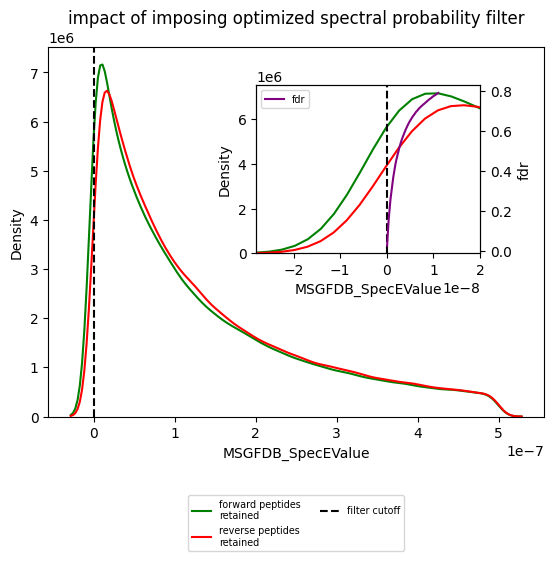

In [10]:
#initial guess at a log10 spectral probability filter value
initial_specprob_filter = -15

#perform optimization
optimization = agg_func.optimize_specFilt(initial_specprob_filter,forward_peptides,reversed_peptides)

#visualize optimization
optimization_fig = agg_func.visualize_optimization(optimization,forward_peptides,reversed_peptides)

del initial_specprob_filter

Apply the filter to the dataset and recalculate peptide and spectral FDR

In [11]:
#Filter the data according to the filter and recalculate FDR
forward_peptides = forward_peptides[
    (forward_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

reversed_peptides = reversed_peptides[
    (reversed_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

# Calculate FDR
f_spec = (forward_peptides["SpecID"].unique().size)
r_spec = reversed_peptides["SpecID"].unique().size
if (f_spec == 0) & (r_spec == 0):
    fdr_spec = 1
else:
    fdr_spec = (2*r_spec) / (f_spec + r_spec)

f_pep = forward_peptides["Peptide Sequence with Mods"].unique().size
r_pep = reversed_peptides["Peptide Sequence with Mods"].unique().size
if (f_pep == 0) & (r_pep == 0):
    fdr_pep = 1
else:
    fdr_pep = (r_pep) / (f_pep + r_pep)

del f_spec, r_spec, f_pep, r_pep

print("Spectral FDR:",fdr_spec,"\nPeptide FDR:",fdr_pep)


Spectral FDR: 0.04997791380071938 
Peptide FDR: 0.055613538094528105


## 3) Collapse to unique peptides and normalize their relative abundance

Visualize the untransformed and un-normalized relative abundances

Text(0, 0.5, 'Relative Peptide Abundance (Un-Normalized)')

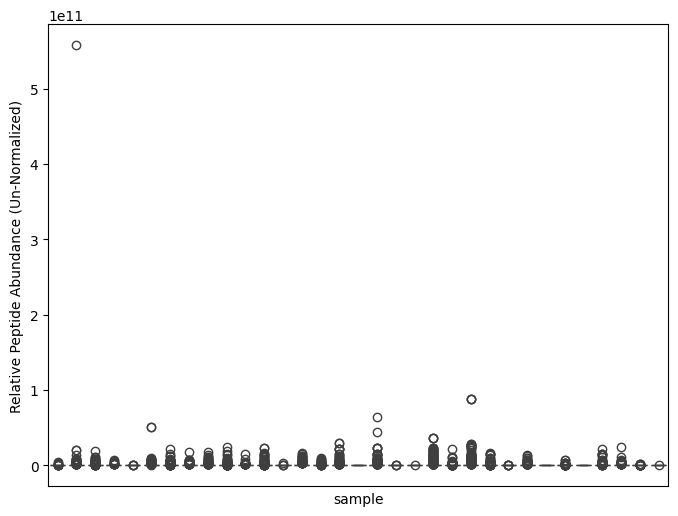

In [12]:
#extract data set id
forward_peptides['processed_DO_id'] = forward_peptides['SpecID'].str.split('_').str[0]

#plot untransformed abundance values
untransformed_abundances_fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='processed_DO_id',y='StatMomentsArea',data=forward_peptides)
plt.xticks([])
plt.xlabel('sample')
plt.ylabel('Relative Peptide Abundance (Un-Normalized)')

Apply log2 transformation and median normalize peptide abundances

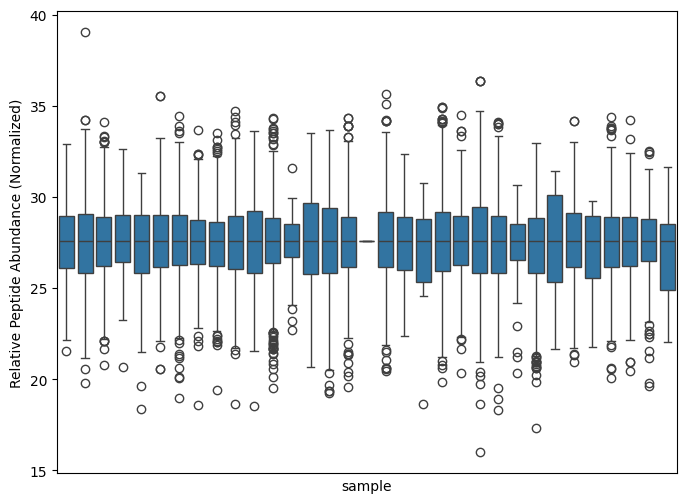

In [13]:
#log2 tranformation
forward_peptides['StatMomentsAreaLog2']=np.log2(forward_peptides['StatMomentsArea'])

# Calculate group-wise (sample wise) median
group_medians = forward_peptides.groupby('processed_DO_id')['StatMomentsAreaLog2'].median()

# Calculate data wide median
all_data_median=forward_peptides['StatMomentsAreaLog2'].median()

# Subtract sample wise median from each value within its group
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides.apply(
    lambda row: row['StatMomentsAreaLog2'] - group_medians[row['processed_DO_id']], axis=1
)

#add back in a data wide median value to avoid negative abundances
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides['StatMomentsAreaLog+Norm'] + all_data_median

transformed_abundances_fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='processed_DO_id',y='StatMomentsAreaLog+Norm',data=forward_peptides)
plt.xticks([])
plt.xlabel('sample')
plt.ylabel('Relative Peptide Abundance (Normalized)')

del ax, group_medians, all_data_median, forward_peptides['StatMomentsArea'], forward_peptides['StatMomentsAreaLog2'], reversed_peptides

At this point in analysis the data has been filtered to only high probability peptide identifications, but more than one scan within a dataset can have the same peptide identification. This can be due to the peptide eluting into the mass spectrometer over the course of multiple scans. Sum the relative abundance for peptide sequences detected more than once in a dataset, leaving a total relative abundance value for each peptide in each dataset

In [14]:
#drop SpecID and spectral probability columns since no longer relevant
forward_peptides.drop(['SpecID','MSGFDB_SpecEValue'],axis=1, inplace=True)

#for each peptide sequence with mods, sum the abundances for all scans/identifications
forward_peptides = forward_peptides.groupby(['processed_DO_id','Peptide Sequence with Mods'])['StatMomentsAreaLog+Norm'].sum().to_frame().reset_index()

display(forward_peptides)

,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,AALAANSELMNK,27.600737
1,nmdc:dobj-11-2k6s1505,AFTVDEMR,26.634867
2,nmdc:dobj-11-2k6s1505,AGGSITSSGGVERNDVDYSAVLTK,23.278834
...,...,...,...
12100,nmdc:dobj-11-zn9eyg46,VAELEATTAR,60.339342
12101,nmdc:dobj-11-zn9eyg46,VAELEATTVR,27.188419
12102,nmdc:dobj-11-zn9eyg46,WLWNYYQYYK,22.022224


## 4) Extract functional gene annotations for proteins

Collect peptide to protein mapping information for the passing peptide sequences

In [15]:
peptide_protein_mapping = pd.DataFrame(unfilt_res[unfilt_res['Peptide Sequence with Mods'].isin(forward_peptides['Peptide Sequence with Mods'])][['Peptide Sequence with Mods','Protein']].drop_duplicates()).reset_index(drop=True)
peptide_protein_mapping

,Peptide Sequence with Mods,Protein
0,NLTTGPGSAQEAIFNR,nmdc:wfmgan-11-z0q72297.1_004752_2_691
1,TYTLRPGAVAEFEER,nmdc:wfmgan-11-z0q72297.1_013275_1_561
2,ELASSAAYTTIQTVK,nmdc:wfmgan-11-z0q72297.1_056571_1_339
...,...,...
20302,AHLDQIVTR,nmdc:wfmgan-11-z0raab34.1_002480_199_1413
20303,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_005022_699_1082
20304,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_024291_3_491


Annotation information for these proteins can be found in 'Functional Annotation GFF' files.

Since the `data_objects` dataframe contains all objects associated with our study id, it also contains the relevant 'Functional Annotation GFF' files. Subset this dataframe to GFF files associated with the 33 biosample ids that have a proteomic output in `proteomic_output_df`

In [16]:
annotation_input_df = data_objects[(data_objects['data_object_type']=='Functional Annotation GFF') & (data_objects['biosample_id'].isin(proteomic_output_df['biosample_id'].unique().tolist()))].reset_index(drop=True)
display(annotation_input_df)

,id,name,description,file_size_bytes,data_object_type,type,md5_checksum,url,was_generated_by,biosample_id,alternative_identifiers,in_manifest,data_category
0,nmdc:dobj-11-cncace51,nmdc_wfmgan-11-z0q72297.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-z0q72...,41027989.0,Functional Annotation GFF,nmdc:DataObject,d4f6008ecb2a990fdd533365d16f547b,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-kcdh3w94,NaN,NaN,NaN
1,nmdc:dobj-11-c24s6186,nmdc_wfmgan-11-ewrwts75.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-ewrwt...,114196066.0,Functional Annotation GFF,nmdc:DataObject,3049a60a48baca9133461a7cde827b6f,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-1p0tct86,NaN,NaN,NaN
2,nmdc:dobj-11-p55wx268,nmdc_wfmgan-11-vcrp9p47.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-vcrp9...,36135504.0,Functional Annotation GFF,nmdc:DataObject,56ca7bb11c7a299af52bfb23d2bfefa0,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-2fw5j754,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,nmdc:dobj-11-f6n2bs50,nmdc_wfmgan-11-v53k8v91.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-v53k8...,69287553.0,Functional Annotation GFF,nmdc:DataObject,4c2d463ad8a820bcbab591e6c398932e,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-3pvn5d70,NaN,NaN,NaN
31,nmdc:dobj-11-sr07nm98,nmdc_wfmgan-11-b431tg70.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-b431t...,66352443.0,Functional Annotation GFF,nmdc:DataObject,d29c8717338d7b1c47b07182cd576443,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-amdcp906,NaN,NaN,NaN
32,nmdc:dobj-11-2yvsr009,nmdc_wfmgan-11-z0raab34.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-z0raa...,59167081.0,Functional Annotation GFF,nmdc:DataObject,41a3766ddaf4dc0b2f20a3ce0d69647c,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-vqk1y255,NaN,NaN,NaN


Examine the information in these 'Functional Annotation GFF' files

In [17]:
#example annotation file
annotation_file=annotation_input_df.iloc[0]["url"]
print(annotation_file)
display(agg_func.gff_extract_features(annotation_file))

del annotation_file

https://data.microbiomedata.org/data/nmdc:omprc-13-z37b9193/nmdc:wfmgan-11-z0q72297.1/nmdc_wfmgan-11-z0q72297.1_functional_annotation.gff


,ID,translation_table,start_type,product,product_source,cath_funfam,cog,ko,pfam,superfamily,...,note,number_of_repeats,average_repeat_length,median_repeat_length,average_spacer_length,median_spacer_length,Parent,ncRNA_class,regulatory_class,bound_moiety
0,nmdc:wfmgan-11-z0q72297.1_000001_7_501,11,ATG,uncharacterized protein,KO:K09129,3.40.1520.10,COG1839,KO:K09129,PF04008,103165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nmdc:wfmgan-11-z0q72297.1_000001_822_2396,11,ATG,circadian clock protein KaiC,KO:K08482,3.40.50.300,COG0467,KO:K08482,PF06745,52540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nmdc:wfmgan-11-z0q72297.1_000001_2472_2807,11,ATG,hypothetical protein,Hypo-rule applied,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144459,nmdc:wfmgan-11-z0q72297.1_118419_2_199,11,ATG,carbamoyl-phosphate synthase large subunit,KO:K01955,3.30.470.20,COG0458,KO:K01955,PF02786,56059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144460,nmdc:wfmgan-11-z0q72297.1_118420_2_199,11,Edge,aryl-alcohol dehydrogenase-like predicted oxid...,COG0667,3.20.20.100,COG0667,NaN,PF00248,51430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144461,nmdc:wfmgan-11-z0q72297.1_118421_73_201,11,Edge,hypothetical protein,Hypo-rule applied,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract information from all 33 annotation files (this takes a while to run) and merge with `razormapping` so there is a final table of peptide-protein-annotation mapping (`annotation_mapping`)

In [18]:
#get gene annotation information for proteins
genemapping = annotation_input_df[["id", "url"]].drop_duplicates().reset_index(drop=True)

genemapping = agg_func.iterate_file_extract(
    pd_df=genemapping,\
    identifier_col='id',\
    url_col='url',\
    extract_cols=['ID','product','product_source'],\
    filter_col = 'ID',
    filter_values = peptide_protein_mapping['Protein'].unique().tolist(),
    file_type='gff'
)

#merge with razor protein mapping information
annotation_mapping = genemapping.merge(peptide_protein_mapping,left_on='ID',right_on='Protein').drop('ID',axis=1)

annotation_mapping

,product,product_source,id_col,Peptide Sequence with Mods,Protein
0,hypothetical protein,Hypo-rule applied,nmdc:dobj-11-cncace51,AMERGETYVNVHTEKNPNGEIR,nmdc:wfmgan-11-z0q72297.1_000027_1367_1870
1,carboxymethylenebutenolidase,KO:K01061,nmdc:dobj-11-cncace51,GVGHAFANPSGENYAPK,nmdc:wfmgan-11-z0q72297.1_000043_2237_3076
2,nitrite reductase (NO-forming),KO:K00368,nmdc:dobj-11-cncace51,LLSDNPDLVLTNGMAHK,nmdc:wfmgan-11-z0q72297.1_000048_1_840
...,...,...,...,...,...
20302,acetoacetate decarboxylase,COG4689,nmdc:dobj-11-2yvsr009,SPDGNTYYGGYYPYMYLTQDAAVFAGREPFGFPK,nmdc:wfmgan-11-z0raab34.1_167280_3_278
20303,basic membrane protein A and related proteins,KO:K07335,nmdc:dobj-11-2yvsr009,GFNEFSIAGFER,nmdc:wfmgan-11-z0raab34.1_167989_2_277
20304,basic membrane protein A and related proteins,KO:K07335,nmdc:dobj-11-2yvsr009,AQEELGVDGR,nmdc:wfmgan-11-z0raab34.1_167989_2_277


## 5) Generate annotation and protein mappings for peptides using "Razor" strategy

Identify the razor protein, which is a method of limiting the assignment of degenerate peptides (i.e., peptides that map to more than one forward protein) to a most likely matched protein.

The rules are as follows:
- If a peptide is unique to a protein, then that is the razor
- If a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the razor
- If a peptide belongs to more than one protein and one of those proteins has has the maximal number of peptides, then that protein is the razor
- If a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then collapse the proteins and gene annotations into single strings
- If a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

Use `annotation_mapping` as the input to the function razorprotein() from the agg_func script. This will return protein and gene annotation information for each peptide, according to the above rules. 

In [19]:
razormapping = agg_func.razorprotein(annotation_mapping)
razormapping

,product,product_source,id_col,Peptide Sequence with Mods,razor
0,dodecin,KO:K09165,nmdc:dobj-11-gz45zh89,AAAAAIATASR,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,dodecin,KO:K09165,nmdc:dobj-11-2q5dgh56,AAAAAIETASR,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,"dodecin, dodecin, dodecin, dodecin, dodecin","KO:K09165, KO:K09165, KO:K09165, KO:K09165, KO...","nmdc:dobj-11-7skrdz46, nmdc:dobj-11-sr07nm98, ...",AAAAAVETASR,"nmdc:wfmgan-11-6pq4bd13.1_044073_3_326, nmdc:w..."
...,...,...,...,...,...
5990,peptide/nickel transport system substrate-bind...,KO:K02035,nmdc:dobj-11-gz45zh89,YYQDHFGQYGKGDVAGAQK,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
5991,YgiT-type zinc finger domain-containing protei...,"TIGR03831, Hypo-rule applied","nmdc:dobj-11-2f3gzn94, nmdc:dobj-11-gz45zh89",YYSADTLK,"nmdc:wfmgan-11-21ms6426.1_119378_95_340, nmdc:..."
5992,uncharacterized protein,KO:K06996,nmdc:dobj-11-f6n2bs50,YYSELFGWQVHEVMPTYGLVHTEAGGK,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


## 6) Gather metadata for the 33 biosamples associated with these processed datasets

Gather biosample metadata via the NMDC API `collection` endpoint, using the function get_id_results() in api_func and searching for the `biosample_id`s associated with each output in `proteomic_output_df`

In [20]:
#collect biosample metadata via the API
biosamples = api_func.get_id_results(newest_results = proteomic_output_df.to_dict(orient='records'), 
                                     id_field = 'biosample_id', 
                                     query_collection = 'biosample_set', 
                                     match_id_field = 'id', 
                                     query_fields = 'id,depth.has_numeric_value')

#normalize the json columns
biosamples = pd.json_normalize(biosamples).drop_duplicates().rename(columns={'id':'biosample_id'})

#merge biosample and processed data object information
sample_metadata = biosamples.merge(proteomic_output_df[['processed_DO_id','biosample_id']],on='biosample_id')
del biosamples

sample_metadata

,biosample_id,depth.has_numeric_value,processed_DO_id
0,nmdc:bsm-13-0jw5n594,0.0,nmdc:dobj-11-pxnhdj84
1,nmdc:bsm-13-13145k83,0.2,nmdc:dobj-11-xm1yjv87
2,nmdc:bsm-13-1p0tct86,0.2,nmdc:dobj-11-bxyvx506
...,...,...,...
30,nmdc:bsm-13-xvf06c81,0.4,nmdc:dobj-11-m808mj05
31,nmdc:bsm-13-yjp2dx65,0.1,nmdc:dobj-11-301yh759
32,nmdc:bsm-13-zms1jq91,0.5,nmdc:dobj-11-sx7cyr58


Assess the number of samples collected at each depth

In [21]:
display(sample_metadata[['depth.has_numeric_value']].value_counts().reset_index())

,depth.has_numeric_value,count
0,0.0,6
1,0.3,6
2,0.4,6
3,0.1,5
4,0.2,5
5,0.5,5


## 7) Perform protein rollup and summarize into a final aggregated table of relative protein abundance

Combine razor information with relative abundance values

In [22]:
#merge needs to be 'right' because some peptides are removed in mapping functions if they have indeterminante mappings
forward_peptides = forward_peptides.merge(razormapping,how='right',on=['Peptide Sequence with Mods'])
#del razormapping, peptide_protein_mapping, genemapping

forward_peptides

,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm,product,product_source,id_col,razor
0,nmdc:dobj-11-jqrf1211,AAAAAIATASR,30.109155,dodecin,KO:K09165,nmdc:dobj-11-gz45zh89,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,nmdc:dobj-11-vjmd5h28,AAAAAIETASR,30.839413,dodecin,KO:K09165,nmdc:dobj-11-2q5dgh56,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,nmdc:dobj-11-tk9hc081,AAAAAVETASR,29.549325,"dodecin, dodecin, dodecin, dodecin, dodecin","KO:K09165, KO:K09165, KO:K09165, KO:K09165, KO...","nmdc:dobj-11-7skrdz46, nmdc:dobj-11-sr07nm98, ...","nmdc:wfmgan-11-6pq4bd13.1_044073_3_326, nmdc:w..."
...,...,...,...,...,...,...,...
10574,nmdc:dobj-11-jqrf1211,YYQDHFGQYGKGDVAGAQK,54.896380,peptide/nickel transport system substrate-bind...,KO:K02035,nmdc:dobj-11-gz45zh89,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
10575,nmdc:dobj-11-sx7cyr58,YYSADTLK,29.721791,YgiT-type zinc finger domain-containing protei...,"TIGR03831, Hypo-rule applied","nmdc:dobj-11-2f3gzn94, nmdc:dobj-11-gz45zh89","nmdc:wfmgan-11-21ms6426.1_119378_95_340, nmdc:..."
10576,nmdc:dobj-11-7psagy79,YYSELFGWQVHEVMPTYGLVHTEAGGK,27.078081,uncharacterized protein,KO:K06996,nmdc:dobj-11-f6n2bs50,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


De-log the peptide abundances, sum the abundances for each razor protein then relog transform the rolled up protein abundances

In [23]:
#de-log abundance
forward_peptides['StatMomentsAreaNorm']=2**forward_peptides['StatMomentsAreaLog+Norm']
forward_peptides.drop('StatMomentsAreaLog+Norm',axis=1,inplace=True)

#sum abundance for each sorted_list protein in each dataset
prot_info = forward_peptides.columns[~forward_peptides.columns.isin(['StatMomentsAreaNorm','Peptide Sequence with Mods'])].tolist()
protein_abundances = forward_peptides.groupby(prot_info)['StatMomentsAreaNorm'].sum().reset_index()

#re-log2 tranform abundance
protein_abundances['StatMomentsAreaLog+Norm']=np.log2(protein_abundances['StatMomentsAreaNorm'])
protein_abundances.drop('StatMomentsAreaNorm',axis=1,inplace=True)

del prot_info, forward_peptides

protein_abundances

,processed_DO_id,product,product_source,id_col,razor,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,"DNA-binding protein HU-beta, DNA-binding prote...","KO:K03530, KO:K03530","nmdc:dobj-11-q0k52648, nmdc:dobj-11-c24s6186","nmdc:wfmgan-11-8zxjs882.1_040719_104_331, nmdc...",25.090841
1,nmdc:dobj-11-2k6s1505,DNA-binding transcriptional LysR family regula...,"COG0583, COG0583, COG0583, COG0583, COG0583","nmdc:dobj-11-2f3gzn94, nmdc:dobj-11-dyq78w56, ...","nmdc:wfmgan-11-21ms6426.1_010178_1_894, nmdc:w...",26.235653
2,nmdc:dobj-11-2k6s1505,DNA-directed RNA polymerase subunit beta',KO:K03046,nmdc:dobj-11-92qp1w39,nmdc:wfmgan-11-yjeh0m30.1_003176_3_1979,26.945549
...,...,...,...,...,...,...
8090,nmdc:dobj-11-zn9eyg46,peptidoglycan/xylan/chitin deacetylase (PgdA/C...,"COG0726, COG0726, COG0726","nmdc:dobj-11-7skrdz46, nmdc:dobj-11-4kn1g186, ...","nmdc:wfmgan-11-6pq4bd13.1_001294_1_411, nmdc:w...",24.607688
8091,nmdc:dobj-11-zn9eyg46,"photosystem II CP43 chlorophyll apoprotein, ph...","KO:K02705, KO:K02705, KO:K02705","nmdc:dobj-11-ysn0es28, nmdc:dobj-11-cncace51, ...","nmdc:wfmgan-11-hyze3t58.1_07201_3_464, nmdc:wf...",28.083196
8092,nmdc:dobj-11-zn9eyg46,predicted porin,COG3203,nmdc:dobj-11-ysn0es28,nmdc:wfmgan-11-hyze3t58.1_02099_286_783,28.625736


## Final aggregated table of relative protein abundance

Reformat these results into a proteomic table, where each row indicates a protein and each column indicates a sample/dataset. The values within are log transformed, median normalized relative abundance values. This table or the longform version above can be used in further proteomic analyses

In [24]:
#pivot to wide crosstab
aggregated_proteomic_output = protein_abundances.pivot(index='razor',columns='processed_DO_id',values='StatMomentsAreaLog+Norm')
aggregated_proteomic_output.columns.name = None

aggregated_proteomic_output

,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2szyc560,nmdc:dobj-11-301yh759,nmdc:dobj-11-3378mg86,nmdc:dobj-11-3ak2bc31,nmdc:dobj-11-4bwzhs42,nmdc:dobj-11-7psagy79,nmdc:dobj-11-7r5yea49,nmdc:dobj-11-7x21d450,nmdc:dobj-11-bxyvx506,...,nmdc:dobj-11-vjmd5h28,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-x6srbx72,nmdc:dobj-11-xm1yjv87,nmdc:dobj-11-y2aefn18,nmdc:dobj-11-yrbs4v96,nmdc:dobj-11-z47wnf07,nmdc:dobj-11-z8hc0j30,nmdc:dobj-11-zhz66007,nmdc:dobj-11-zn9eyg46
razor,,,,,,,,,,,,,,,,,,,,,
nmdc:wfmgan-11-21ms6426.1_000036_702_1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"nmdc:wfmgan-11-21ms6426.1_000053_3_563, nmdc:wfmgan-11-p3dkkz54.1_008013_251_1072",NaN,NaN,NaN,NaN,NaN,NaN,111.546550,NaN,NaN,NaN,...,103.969350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"nmdc:wfmgan-11-21ms6426.1_000057_4146_5369, nmdc:wfmgan-11-p3dkkz54.1_002120_389_1612, nmdc:wfmgan-11-z0raab34.1_009908_3_737",NaN,30.144867,28.416203,28.786161,NaN,NaN,30.520379,NaN,NaN,55.20339,...,30.487015,26.597519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nmdc:wfmgan-11-z0raab34.1_148395_2_283,NaN,60.829026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_160266_3_278,NaN,27.827188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_167280_3_278,NaN,24.794214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While this example dataset does not include technical replicates, other datasets could be aggregated in a similar fashion, with use case adjustments being made as needed. Results could be used as protein level input to the software [pmartR](https://shinyproxy.emsl.pnnl.gov/app/pmart), which can perform statistical analyses including ANOVA and independence of missing data (IMD) tests. In this case, the aggregated proteomics table (`aggregated_proteomic_output`) would be equivalent to pmartR's `e_data`, the biosample metadata (`sample_metadata`) would be equivalent to pmartR's `f_data`, and the peptide to protein to gene mappings (`razor_mapping`) would be equivalent to pmartR's `e_meta`. 


<img src="../pmartR_logo_final.jpg" width="25%"/>